# Part 1: Basic Setup and Imports

In [ ]:
# Import necessary libraries
# Basic Python libraries for various operations
import random
import copy
import re
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from PIL import Image

from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from transformers.modeling_outputs import CausalLMOutputWithPast
from prismatic.models.backbones.llm.prompting import PurePromptBuilder
from prismatic.util.data_utils import PaddedCollatorForActionPrediction
from prismatic.vla.action_tokenizer import ActionTokenizer

from libero.libero import benchmark, get_libero_path
from libero.libero.envs import OffScreenRenderEnv

def set_random_seed(seed: int = 42):
    """
    Set the random seed for reproducibility across Python, NumPy, and PyTorch.

    Args:
        seed (int): The seed value to use for random number generation.

    Returns:
        None

    Explanation:
        1. Sets seed for Python's built-in random module for basic random operations.
        2. Sets seed for NumPy, ensuring consistent random number generation in array operations.
        3. Sets seed for PyTorch CPU operations.
        4. If CUDA is available, sets seed for all GPU devices.
        5. Configures cuDNN to ensure deterministic behavior:
           - Sets deterministic flag to True, ensuring reproducible results.
           - Disables benchmarking to prevent algorithm selection based on hardware.

    Note:
        Setting deterministic behavior may impact performance but ensures consistent results
        across multiple runs, which is crucial for debugging and research.
    """
    # Set the seed for Python's built-in random module
    random.seed(seed)
    # Set the seed for NumPy
    np.random.seed(seed)
    # Set the seed for PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior in cuDNN (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def resize_image(img, resize_size):
    """Takes numpy array corresponding to a single image and returns resized image as numpy array."""
    assert isinstance(resize_size, tuple)
    img = Image.fromarray(img)
    BRIDGE_ORIG_IMG_SIZE = (256, 256)
    img = img.resize(BRIDGE_ORIG_IMG_SIZE, Image.Resampling.LANCZOS)
    img = img.resize(resize_size, Image.Resampling.LANCZOS)  # also resize to size seen at train time
    img = img.convert("RGB")
    img = np.array(img)
    return img

# Call the function to set random seed for reproducibility
set_random_seed(42)

# Set environment variables for Weights & Biases (wandb) logging
os.environ["WANDB_API_KEY"] = "USE YOUR KEY"
os.environ["WANDB_PROJECT"] = "GRPO-Qwen-1.5-Instruct-Multi-GPU"

/home/ubuntu/miniconda3/envs/eric/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-08 10:59:24.465780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 10:59:24.478621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754621964.491732 3970248 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754621964.495729 3970248 cuda_blas.cc:14

In [ ]:
Class Rl4VlaConfig:
    """ Model Configuration """
    vla_sft_model_path: str = "openvla_models/openvla-7b"
    use_quantization: bool = True

    """ Environment Configuration """
    env_name: str = "libero"
    env_version: str = "1.0"
    task_type: str = "pick_place"
    task_id: int = 0

# Part 2: Load the OpenVLA Model and Try It Out

OpenVLA (Open Visual Language Architecture) is a powerful open-source framework designed for multimodal learning and vision-language tasks. It provides a unified architecture that can process both visual and textual information, enabling applications like image captioning, visual question answering, and multimodal reasoning. The framework is built on modern deep learning principles and supports easy integration with popular deep learning libraries, making it accessible for researchers and developers working on computer vision and natural language processing projects.

### Download the OpenVLA Model

In [ ]:
!mkdir openvla_models
!cd openvla_models
!git clone https://huggingface.co/openvla/openvla-7b-finetuned-libero-spatial

### Load the OpenVLA Model

In [3]:
def get_vla(vla_model_family_name, vla_model_path):
    processor = AutoProcessor.from_pretrained(vla_model_family_name, trust_remote_code=True)
    vla = AutoModelForVision2Seq.from_pretrained(
        vla_model_path, 
        attn_implementation="flash_attention_2",  # [Optional] Requires `flash_attn`
        torch_dtype=torch.bfloat16, 
        low_cpu_mem_usage=True, 
        trust_remote_code=True
    ).to("cuda:0")
    return vla, processor
# vla, processor = get_vla("openvla/openvla-7b", "openvla_models/openvla-7b-finetuned-libero-spatial")

In [7]:
# Grab image input & format prompt
image = Image.open("libero.jpg")
prompt = "In: What action should the robot take to {<INSTRUCTION>}?\nOut:"

# Predict Action (7-DoF; un-normalize for BridgeData V2)
inputs = processor(prompt, image).to("cuda:0", dtype=torch.bfloat16)
action = vla.predict_action(**inputs, unnorm_key="libero_spatial", do_sample=False)
print("Action:", action)

Action: [ 6.57004465e-01  4.68907577e-01 -9.79936990e-02  4.83198201e-05
 -2.96638754e-03 -1.02268926e-02  9.96078431e-01]


So far we have successfully loaded the OpenVLA and 

# Part 3: Load the LIBERO Environment and Try It Out

In [ ]:
!git clone https://github.com/Lifelong-Robot-Learning/LIBERO.git
!cd LIBERO
!pip install -r requirements.txt

In [7]:
def get_libero_env(task_id, task_suite_name, seed):
    # retrieve a specific task
    benchmark_dict = benchmark.get_benchmark_dict()
    task_suite = benchmark_dict[task_suite_name]()
    task = task_suite.get_task(task_id)

    task_name = task.name
    task_description = task.language
    task_bddl_file = os.path.join(get_libero_path("bddl_files"), task.problem_folder, task.bddl_file)

    print(f"[INFO] Retrieving task {task_id} from suite {task_suite_name}")
    print(f"[INFO] The language instruction is {task_description}")
    print(f"[INFO] And the bddl file is {task_bddl_file}")

    env_args = {
        "bddl_file_name": task_bddl_file,
        "camera_heights": 128,
        "camera_widths": 128
    }
    env = OffScreenRenderEnv(**env_args)

    env.seed(seed)
    env.reset()

    init_states = task_suite.get_task_init_states(task_id) # for benchmarking purpose, we fix the a set of initial states
    init_state_id = 0
    env.set_init_state(init_states[init_state_id])

    return task_name, task_description, env

def resize_image(img, resize_size):
    """Takes numpy array corresponding to a single image and returns resized image as numpy array."""
    assert isinstance(resize_size, tuple)
    img = Image.fromarray(img)
    BRIDGE_ORIG_IMG_SIZE = (256, 256)
    img = img.resize(BRIDGE_ORIG_IMG_SIZE, Image.Resampling.LANCZOS)
    img = img.resize(resize_size, Image.Resampling.LANCZOS)  # also resize to size seen at train time
    img = img.convert("RGB")
    # img = np.array(img)
    return img

def get_libero_image(obs, resize_size):
    agentview_image = obs['agentview_image']
    # NOTE: rotate 180 degrees to match train preprocessing
    agentview_image = agentview_image[::-1, ::-1]
    agentview_image = resize_image(agentview_image, resize_size)
    return agentview_image

# task_name, task_description, env = get_libero_env(task_id=0, task_suite_name='libero_spatial', seed=0)

# dummy_action = [0.] * 7
# for step in range(10):
#     obs, reward, done, info = env.step(dummy_action)
# env.close()

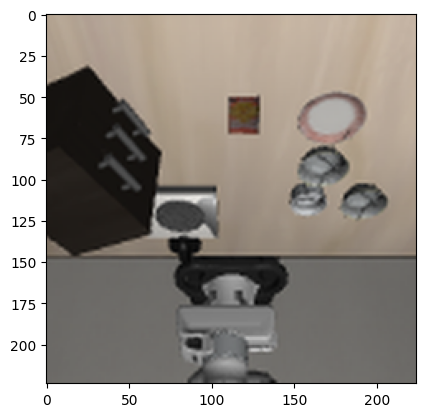

In [ ]:
# Extract the image observation and display it
img = get_libero_image(obs, (224, 224))
plt.imshow(img)
plt.show()

# Part 4: Use the Finetuned Model to Interact with the LIBERO Environment

In [ ]:
# Load the VLA model
vla, processor = get_vla("openvla/openvla-7b", "openvla_models/openvla-7b-finetuned-libero-spatial")
# Create the environment
task_name, task_description, env = get_libero_env(task_id=0, task_suite_name='libero_spatial', seed=0)

prompt = "In: What action should the robot take to {<INSTRUCTION>}?\nOut:"
prompt = prompt.replace("<INSTRUCTION>", task_description)
print('[INFO]', prompt)
 # Execute the dummy action and get the first observation

08/08 [11:00:05] WARNING  | >> Expected `transformers==4.40.1` and `tokenizers==0.19.1`   ]8;id=234053;file:///home/ubuntu/.cache/huggingface/modules/transformers_modules/openvla/openvla-7b/31f090d05236101ebfc381b61c674dd4746d4ce0/modeling_prismatic.py\modeling_prismatic.py]8;;\:]8;id=146316;file:///home/ubuntu/.cache/huggingface/modules/transformers_modules/openvla/openvla-7b/31f090d05236101ebfc381b61c674dd4746d4ce0/modeling_prismatic.py#228\228]8;;\
                          but got `transformers==4.48.2` and `tokenizers==0.21.4`; there                           
                          might be inference-time regressions due to dependency changes.                           
                          If in doubt, pleaseuse the above versions.                                               

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[INFO] Retrieving task 0 from suite libero_spatial
[INFO] The language instruction is pick up the black bowl between the plate and the ramekin and place it on the plate
[INFO] And the bddl file is /home/ubuntu/code/ERIC/LIBERO/libero/libero/./bddl_files/libero_spatial/pick_up_the_black_bowl_between_the_plate_and_the_ramekin_and_place_it_on_the_plate.bddl
[INFO] In: What action should the robot take to pick up the black bowl between the plate and the ramekin and place it on the plate?
Out:


In [ ]:
# Step the environment
frames = []
for i in range(220):
    if i < 10:
        dummy_action = [0.] * 7
        obs, _, _, _ = env.step(dummy_action)
        continue

    # The resize shape depends on the visual backend used in the VLA model
    agentview_image = get_libero_image(obs, (224, 224))
    frames.append(np.array(agentview_image))

    vla_inputs = processor(prompt, agentview_image).to("cuda:0", dtype=torch.bfloat16)
    action = vla.predict_action(**vla_inputs, unnorm_key="libero_spatial", do_sample=False)
    obs, reward, done, info = env.step(action)

    if i % 10 == 0:
        print(i, action, reward, done, info)

    if done:
        break

[-2.98502990e-03 -1.38654779e-03  9.26365527e-02  4.83198201e-05
  1.27899154e-01 -2.18739514e-02  0.00000000e+00] 0.0 False {}
[-2.98502990e-03 -1.38654779e-03 -2.67857313e-03  4.83198201e-05
 -8.98319407e-03  1.26048484e-04  0.00000000e+00] 0.0 False {}
[-2.98502990e-03 -1.38654779e-03 -2.67857313e-03  4.83198201e-05
 -8.98319407e-03  1.26048484e-04  0.00000000e+00] 0.0 False {}
[-2.98502990e-03 -1.38654779e-03 -2.67857313e-03  4.83198201e-05
 -8.98319407e-03  1.26048484e-04  0.00000000e+00] 0.0 False {}
[-2.98502990e-03 -1.38654779e-03 -2.67857313e-03  4.83198201e-05
 -8.98319407e-03  1.26048484e-04  0.00000000e+00] 0.0 False {}
[-2.98502990e-03 -1.38654779e-03 -2.67857313e-03  4.83198201e-05
  4.20157232e-05  1.26048484e-04  0.00000000e+00] 0.0 False {}
[-2.98502990e-03 -1.38654779e-03 -2.67857313e-03  4.83198201e-05
  4.20157232e-05  1.26048484e-04  0.00000000e+00] 0.0 False {}
[-2.98502990e-03 -1.38654779e-03 -2.67857313e-03  4.83198201e-05
  4.20157232e-05  1.26048484e-04  0.000

In [13]:
import mediapy as media
media.show_video(frames, fps=30)